In [1]:
import os
import numpy as np
import cv2
import onnx
import onnxruntime
import time
import textwrap
import torch
import math
from math import ceil
from itertools import product as product
import matplotlib.pyplot as plt
from tools import *
from onnx2pytorch import ConvertModel
import torchvision as tv
import torch.nn.functional as F
from torchvision.ops.boxes import box_iou, nms, batched_nms
import warnings 
from cfg import *


from torch_affine_ops import transform_torch, warp_img_torch, SimilarityTransform_torch_2D
warnings.filterwarnings("ignore")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cfg = cfg_re50

session1 = onnx.load("./model_files/onnx/RetinaFace_mobile.onnx")
pytorch_model1 = ConvertModel(session1)
pytorch_model1.eval()
pytorch_model1.to(device)

session2 = onnx.load("./model_files/onnx/2d106det.onnx")
pytorch_model2 = ConvertModel(session2)
pytorch_model2.eval()
pytorch_model2.to(device)

session3 = onnx.load("./model_files/onnx/Amber_Song.dfm")
pytorch_model3 = ConvertModel(session3)
pytorch_model3.eval()
pytorch_model3.to(device)

print("Model Loaded in Pytorch")

Model Loaded in Pytorch


image (1102, 746, 3)
138.0 -115.0


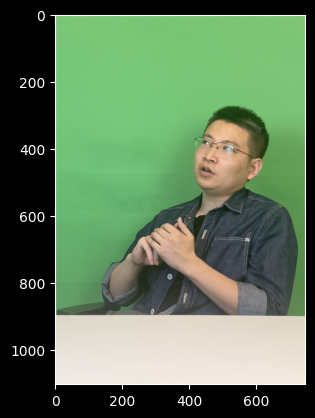

In [3]:
# load image

input_mean = 0.0
input_std = 1.0

img_path = "./align_img/fangzi.jpg"
image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # origin image in BGR
img = np.float32(image)

im_height, im_width, _ = img.shape
scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
scale = scale.to(device)


img -= (104, 117, 123) # mean substruction to reduce illumination changes
img = img.transpose(2, 0, 1)[None, :]

Batch_size = img.shape[0]

# show the origin image
# plt.imshow(image[:,:,::-1]/255)
plt.imshow(image[:,:,::-1]/255)

print("image",image.shape)

print(np.max(img),np.min(img))


Session 1. Bbox detection of Human Face

In [3]:
# # Inference the face detection model, return the bounding boxes and landmarks of all possible faces
# # conf has 2 channels, the first channel is the score of the face, the second channel is the score of the background #loc: B*F*4, conf: B*F*2, landms: B*F*10 = B*F*5*2
with torch.no_grad():
    loc, conf, landms= pytorch_model1(torch.from_numpy(img).to(device))
    
resize = 1

# landms rescalse

scale1 = torch.Tensor([im_width, im_height]).to(device)
landms = (landms.view(Batch_size, -1, 5,2)*scale1)
landms = landms.view(Batch_size, -1, 10)/resize


# conf has 2 channels, the first channel is the score of the face, the second channel is the score of the background
scores = conf[:, :, 1]

print(landms.shape)


NameError: name 'img' is not defined

In [5]:
# boxes reprocess

priorbox = PriorBox(cfg, image_size=(im_height, im_width))
priors = priorbox.forward()
priors = priors.to(device)
prior_data = priors.data
prior_data = priors.data

boxes = batch_decode(loc.data, prior_data.repeat(Batch_size, 1, 1), cfg['variance'])
boxes = boxes * scale / resize

# parameters for nms
confidence_threshold = 0.02
nms_threshold = 0.4
top_k = 5000
keep_top_k = 750

# ignore low scores
inds = torch.where(scores > confidence_threshold)[1]
boxes_filtered = boxes[:,inds, :]
landms_filtered = landms[:,inds,:]
scores_filtered = scores[:,inds]
Batch_id_filtered = torch.arange(Batch_size).view(Batch_size,1).repeat(1,inds.shape[0]).to(device)

nums_index = batched_nms(boxes_filtered.view(-1,4), scores_filtered.view(-1), Batch_id_filtered.view(-1), nms_threshold)


batch_nums_idx = nums_index//Batch_size
Batch_id_index = nums_index%Batch_size



# the best bbox of each face
First_id = torch.zeros(Batch_size).to(device)
boxes_first = torch.zeros(Batch_size,4).to(device)
landms_first = torch.zeros(Batch_size,10).to(device)
scores_first = torch.zeros(Batch_size).to(device)
bi = 0 
for i in range(len(Batch_id_index)):
    if Batch_id_index[i] == bi:
        First_id[bi] = batch_nums_idx[i]
        boxes_first[bi,:] = boxes_filtered[bi, batch_nums_idx[i], :]
        landms_first[bi,:] = landms_filtered[bi, batch_nums_idx[i], :]
        scores_first[bi] = scores_filtered[bi, batch_nums_idx[i]]
        bi = bi + 1

dets = torch.cat([boxes_first, scores_first.view(Batch_size,1)], dim=-1)
dets = torch.cat([dets, landms_first], dim=1)

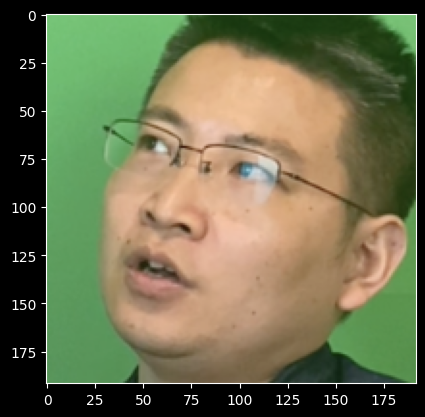

In [6]:
# input_shape2 = B*3*192*192
input_shape2 = ['None', 3, 192, 192]
feed_img = torch.tensor(image,device=device).float()
bbox = boxes_first[:, :4]
bbox_size = bbox[:,2:4] - bbox[:,0:2]
w, h = bbox_size[:,0], bbox_size[:,1]

input_size = tuple(input_shape2[2:4][::-1])
_scale =  1 / bbox_size.max(-1, keepdim=True)[0] * input_size[0]/1.2
center = (bbox[:,0:2] + bbox[:,2:4])/2
#torch.Tensor([(bbox[2] + bbox[0]) / 2, (bbox[3] + bbox[1]) / 2]).to(device)

rotate = torch.zeros(Batch_size).to(device)
#_scale = input_size[0]  / (max(w, h)*1.5)

# transform from origin image to bbox image with input_size
M_torch = transform_torch(center, input_size, _scale, rotate)
IM = torch.linalg.inv(M_torch)[0:2,:]
Jt = warp_img_torch(feed_img.permute(2,0,1).unsqueeze(0), M_torch, input_size)
Jt = torch.clip(Jt, 0, 255)

plt.imshow(Jt[0].permute(1,2,0).cpu().numpy()[:,:,::-1]/255)

Session 2. Keys Points detection for face alignment

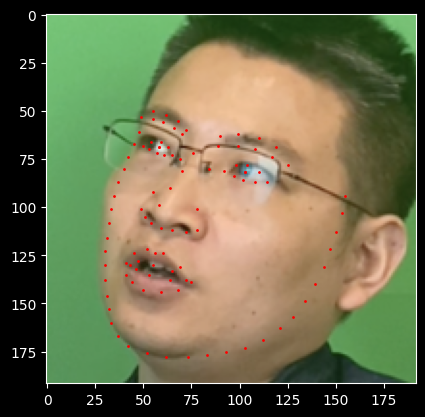

In [7]:
# 106 kpoints
with torch.no_grad():
    pred_kpt = pytorch_model2(Jt)
pred_kpt = pred_kpt.view(1,106,2)
pred_kpt[:,:,0:2] += 1
pred_kpt[:,:,0:2] *= (input_size[0] // 2)

# draw kpoints on image
pred_kpt_np = pred_kpt[0].cpu().numpy()
pred_kpt_np = pred_kpt_np.astype(np.int32)
plt.imshow(Jt[0].permute(1,2,0).cpu().numpy()[:,:,::-1]/255)
plt.scatter(pred_kpt_np[:,0], pred_kpt_np[:,1], s=1, c='r')

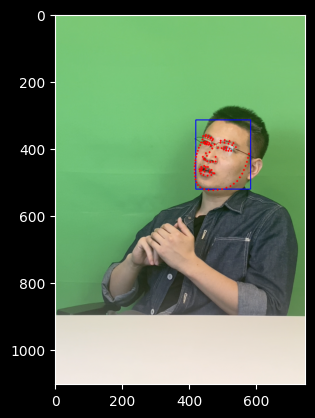

In [8]:
lmrks_on_whole = torch.matmul(pred_kpt,IM[:,0:2,0:2].transpose(-1,-2)) + IM[:,0:2, 2]
#lmrks = torch.round(lmrks).int()
lmrks_on_whole_np = lmrks_on_whole.cpu().numpy()[0]
draw_img_lmks = image.copy()

vis_thres = 0.6
for b in dets:
    if b[4] < vis_thres:
        continue
    text = "{:.4f}".format(b[4])
    b = list(map(int, b))
    cv2.rectangle(draw_img_lmks, (b[0], b[1]), (b[2], b[3]), (255, 0, 0), 2)

for lmrk in lmrks_on_whole_np:
    cv2.circle(draw_img_lmks, (int(lmrk[0]),int(lmrk[1])), 1, (0, 0, 255), 4)

#name = "detect_test.jpg"
# cv2.imwrite(name, draw_img_detect)
#plt.imshow(draw_img_detect[:,:,::-1]/255)
# name = "lmks_test.jpg"
# cv2.imwrite(name, draw_img_lmks)
plt.imshow(draw_img_lmks[:,:,::-1]/255)

In [9]:
lmrks_68 = lmrks_on_whole[:,lmrks_106_to_68_mean_pairs,:].view(Batch_size,68,2,2).mean(-2)
list68to25 = list(range(17,37))+[39,42,45,48,54]
lmrks_25 = lmrks_68[:,list68to25,:].view(Batch_size,25,2)

uni_landmarks_25 = torch.from_numpy(uni_landmarks_68).to(device).unsqueeze(0)
# uni_landmarks_25 = torch.from_numpy(uni_landmarks_68).to(device).repeat(Batch_size,1,1)

Similarity_Matrix_3d_final = SimilarityTransform_torch_2D(lmrks_25, uni_landmarks_25)
Similarity_Matrix_3d_inversed = torch.inverse(Similarity_Matrix_3d_final)

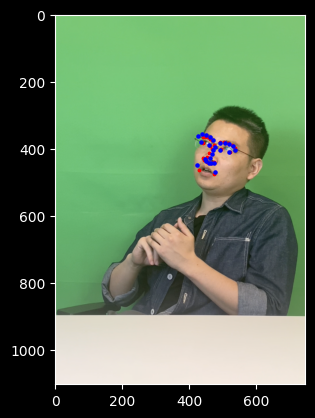

In [10]:
uni_landmarks_25_inversed = torch.matmul(uni_landmarks_25,Similarity_Matrix_3d_inversed[:,:2,:2].transpose(-1,-2)) + Similarity_Matrix_3d_inversed[:,:2,2].unsqueeze(-1).transpose(-1,-2)
uni_landmarks_25_inversed_np = uni_landmarks_25_inversed[0].cpu().numpy()
lmrks_25_np = lmrks_25[0].cpu().numpy()

plt.imshow(image[...,::-1])
plt.scatter(lmrks_25_np[:,0], lmrks_25_np[:,1], c='r', s=3)
plt.scatter(uni_landmarks_25_inversed_np[:,0], uni_landmarks_25_inversed_np[:,1], c='b', s=5)

In [11]:
center

tensor([[499.6954, 418.6730]], device='cuda:0')

In [12]:
def warp_img_torch(img, transform_matrix, output_size):
    device = img.device
    B, C, H, W = img.shape
    T = torch.Tensor([[2 / (W-1), 0, -1],
              [0, 2 / (H-1), -1],
              [0, 0, 1]]).to(device).repeat(B,1,1)
    
    T2 = torch.Tensor([[2 / (output_size[0]-1), 0, -1],[0, 2 / (output_size[1]-1), -1],[0, 0, 1]]).to(device).repeat(B,1,1)
    M_torch = torch.matmul(T2,torch.matmul(transform_matrix,torch.linalg.inv(T)))
    grid_trans = torch.linalg.inv(M_torch)[:,0:2,:]

    #grid_trans[0,:,2] = torch.Tensor([0,0]).to(device)

    grid = F.affine_grid(grid_trans, torch.Size((B, C, output_size[0], output_size[1])))
    img = F.grid_sample(img, grid)
    return img

face_align_img.shape: torch.Size([1, 3, 1102, 1102])
lmrks_align.shape: torch.Size([1, 68, 2])
center_align.shape: torch.Size([1, 1, 2])
torch.Size([1102, 746, 3])
torch.max(face_align_img): tensor(246.5472, device='cuda:0')


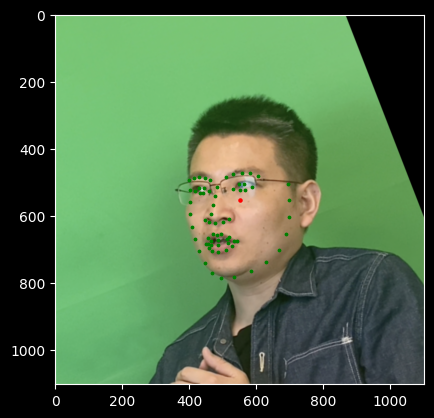

In [30]:
theta = torch.arctan(Similarity_Matrix_3d_final[:,1,0]/Similarity_Matrix_3d_final[:,0,0])*180/torch.pi
#theta = torch.ones_like(theta)*30
output_size = 1102
# output_size_w = 746
# output_size_h = 1102 

coverage = 2

center_0 = 0*torch.tensor(feed_img.shape[:2],device=device).unsqueeze(0)/2

face_align_matrix = transform_torch(center, (2*output_size, 2*output_size), coverage*_scale/_scale, theta)

center_align = torch.matmul(center,face_align_matrix[:,:2,:2].transpose(-1,-2)) + face_align_matrix[:,:2,2]

face_align_matrix[:,:2,2:3] += - center_align.transpose(-1,-2) + output_size/2


face_align_img = warp_img_torch(feed_img.permute(2,0,1).unsqueeze(0), face_align_matrix[0], (output_size, output_size))
face_align_img = torch.clip(face_align_img, 0, 255)


lmrks_align = torch.matmul(lmrks_68,face_align_matrix[:,:2,:2].transpose(-1,-2)) + face_align_matrix[:,:2,2]
lmrks_align_np = lmrks_align[0].cpu().numpy()
center_align = torch.matmul(center,face_align_matrix[:,:2,:2].transpose(-1,-2)) + face_align_matrix[:,:2,2]
center_align_np = center_align[0].cpu().numpy()

plt.imshow(face_align_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)[...,::-1])
plt.scatter(lmrks_align_np[:,0], lmrks_align_np[:,1], c='g', s=3)
plt.scatter(center_align_np[:,0], center_align_np[:,1], c='r', s=5)


print("face_align_img.shape:",face_align_img.shape) # 1 3 500 500 # 用这个做为新image 输入
print("lmrks_align.shape:",lmrks_align.shape) # 1 68 2  # 用这个作为新landmark 输入
print("center_align.shape:",center_align.shape) # 1 1 2
print(feed_img.shape) # 1102 746 3
print("torch.max(face_align_img):",torch.max(face_align_img)) # 255.0



In [14]:
input_size

(192, 192)

recovered_img.shape: torch.Size([1, 3, 1102, 1102])
1102 1102
torch.Size([1, 3, 1102, 746])
tensor(200.9468, device='cuda:0') tensor(0., device='cuda:0')
500


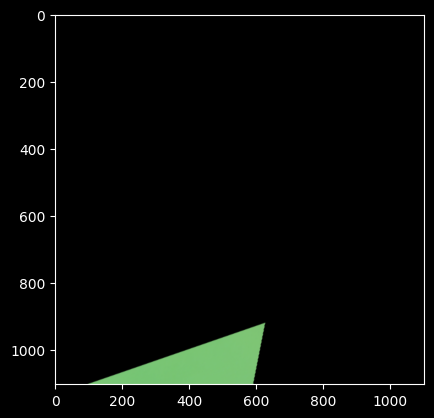

In [15]:
face_align_matrix_reback = transform_torch(center_0, input_size, 1/coverage*_scale/_scale, -theta)

center_align_2 = torch.matmul(output_size/2*torch.ones_like(face_align_matrix[:,:2,2]),face_align_matrix_reback[:,:2,:2].transpose(-1,-2)) + face_align_matrix_reback[:,:2,2]

face_align_matrix_reback[:,:2,2:3] += - center_align_2.transpose(-1,-2) + center.transpose(-1,-2)

# 用这句把图像恢复回来

recovered_img = warp_img_torch(face_align_img, face_align_matrix_reback[0], (feed_img.shape[0], feed_img.shape[0]))

print("recovered_img.shape:",recovered_img.shape) # torch.Size([1, 3, 1102, 1102])
print(feed_img.shape[0], feed_img.shape[0])
print(face_align_img.shape)
print(torch.max(recovered_img), torch.min(recovered_img))
print(output_size)

plt.imshow(recovered_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)[...,::-1])

# 这是正脸化回去的结果，需要一些工程化处理

In [16]:
face_align_matrix_reback

tensor([[[   1.8647,   -0.7230,  214.2666],
         [   0.7230,    1.8647, -228.2663],
         [   0.0000,    0.0000,    1.0000]]], device='cuda:0')

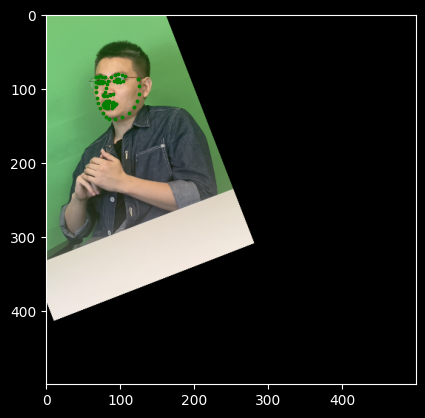

In [17]:

face_align_matrix = transform_torch(center, input_size, _scale*coverage, theta)
face_align_img = warp_img_torch(feed_img.permute(2,0,1).unsqueeze(0), face_align_matrix[0], (output_size, output_size))
face_align_img = torch.clip(face_align_img, 0, 255)
lmrks_align = torch.matmul(lmrks_68,face_align_matrix[:,:2,:2].transpose(-1,-2)) + face_align_matrix[:,:2,2]
lmrks_align_np = lmrks_align[0].cpu().numpy()
plt.imshow(face_align_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)[...,::-1])
plt.scatter(lmrks_align_np[:,0], lmrks_align_np[:,1], c='g', s=3)

In [31]:
print("dengjunli",input_size)

dengjunli (192, 192)


In [ ]:
videowriter_face = cv2.VideoWriter(res_face_path, cv2.VideoWriter_fourcc(*'XVID'), 25, (resize_w, resize_h))

videowriter_face.write(pre_frame[:, :, ::-1].copy().astype(np.uint8))